In [1]:
#Distributions and Modules
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import distributions
import pandas as pd
import numpy as np
from torch import optim
import matplotlib.pyplot as plt

# Import Dataset

In [2]:
df = pd.read_csv("train_FD001.csv") #gamma = 0.9
df = df.drop(columns=["Unnamed: 0"])
df.head(5)

,machine,time,2,3,6,7,8,9,10,11,...,16,17,18,19,20,21,24,25,reward,MC_Val
0,1,1,-0.315972,-1.372920,-1.721684,-0.134252,-0.925914,-0.999976,0.14168,1.121113,...,0.334254,-1.058865,-0.269065,-0.603801,-0.999976,-0.781691,1.348460,1.194398,0,-1.821039e-07
1,1,2,0.872701,-1.031695,-1.061754,0.211523,-0.643710,-0.999976,0.14168,0.431920,...,1.174871,-0.363637,-0.642829,-0.275845,-0.999976,-0.781691,1.016503,1.236892,0,-2.023377e-07
2,1,3,-1.961827,1.015652,-0.661797,-0.413156,-0.525940,-0.999976,0.14168,1.008131,...,1.364688,-0.919819,-0.551616,-0.649128,-0.999976,-2.073044,0.739873,0.503411,0,-2.248197e-07
3,1,4,0.324083,-0.008022,-0.661797,-1.261284,-0.784812,-0.999976,0.14168,1.222798,...,1.961255,-0.224592,-0.520163,-1.971617,-0.999976,-0.781691,0.352590,0.777773,0,-2.497996e-07
4,1,5,-0.864590,-0.690471,-0.621801,-1.251498,-0.301511,-0.999976,0.14168,0.714376,...,1.052846,-0.780774,-0.521736,-0.339837,-0.999976,-0.136014,0.463242,1.059526,0,-2.775551e-07


# Neural Networks for Predictron

In [3]:
#Neural network for Observation - Hidden State

class NN_OH(nn.Module):
    def __init__(self, input_size, out_size):
        super(NN_OH,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,out_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [4]:
#Neural network for Hidden State - Reward, Gamma, Lambda

class NN_reward(nn.Module):
    def __init__(self, input_size):
        super(NN_reward,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,3)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # constrain gamma and lambda to be between 0 and 1 with sigmoid
        x[:, 1:3] = torch.sigmoid(x[:, 1:3])
        return x

In [5]:
#Neural network for Hidden State - Value
class NN_val(nn.Module):
    def __init__(self, input_size):
        super(NN_val,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
transition_matrix = torch.Tensor([[0.347, 0.653, 0.0, 0.0], 
                                     [0.0, 0.652, 0.348, 0.0],
                                     [0.0, 0.0, 0.505, 0.495],
                                     [0.0, 0.0, 0.0, 1.0]])
transition_matrix

tensor([[0.3470, 0.6530, 0.0000, 0.0000],
        [0.0000, 0.6520, 0.3480, 0.0000],
        [0.0000, 0.0000, 0.5050, 0.4950],
        [0.0000, 0.0000, 0.0000, 1.0000]])

In [7]:
# take my current hidden state to the next hidden state
def NN_HH(hidden_state):
    
    # hidden_state is a tensor of shape [*, 4]
    
    transposed_states = torch.transpose(hidden_state, 0, 1)
    return torch.transpose(torch.matmul(transition_matrix, transposed_states), 0, 1)
    

# Predictron

In [8]:
#Now we have all the required neural networks for the predictron. Lets build the Predictron

class Predictronv4(nn.Module):
    def __init__(self, obs_size, hid_size, k=10):
        super(Predictronv4,self).__init__()
        
        #Instantiate Neural Network for Observation-Hidden State
        self.OH = NN_OH(obs_size, hid_size)
        
        #Instantiate Neural Network for Hidden State - Reward, Value
        self.HR = NN_reward(hid_size)
        
        #Instantiate Neural Network for Hidden State - Val
        self.HV = NN_val(hid_size)
        
        #K-step return
        self.k = k
        
    def forward(self, x, isHidden=False):
        """
        
        isHidden - False if x is an observation vector
        
        """
        #First step: Get the Hidden state for the current observation
        if isHidden == False:
            x = self.OH(x)
        
        # Initialize lists
        rewards = []
        gammas = []
        lambdas = []
        values = []
        
        # forward pass
        for k in range(0, self.k + 1):
            
            rewards.append(self.HR(x)[:, 0].reshape(-1, 1))
            gammas.append(self.HR(x)[:, 1].reshape(-1, 1))
            lambdas.append(self.HR(x)[:, 2].reshape(-1, 1))
            values.append(self.HV(x))
            
            #get the next hidden state
            x = NN_HH(x)

        # backwards pass to compute g-lambda
        gl = values[self.k]
        for k in range(0, self.k)[::-1]:
            gl = ((1 - lambdas[k])*values[k]) + (lambdas[k] * (rewards[k+1] + (gammas[k+1]*gl)))
        
        return gl.reshape(-1, 1)

In [9]:
def getXY(data):
    x = torch.tensor(data.iloc[:, 2:-2].values).float()
    y_target = torch.tensor(data.iloc[:,-1].values).float()
    y_target = y_target.reshape(-1,1)
    
    return x, y_target

In [10]:
x, y_target = getXY(df)

# Lambda Predictron: Training Losses

In [11]:
#Defining the loss function and Initialising the Predictron core
k_values = [5, 10, 15, 20]

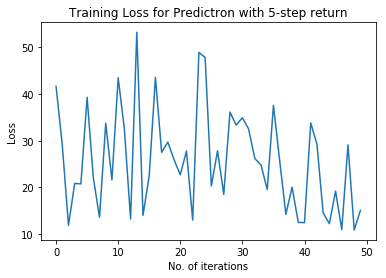

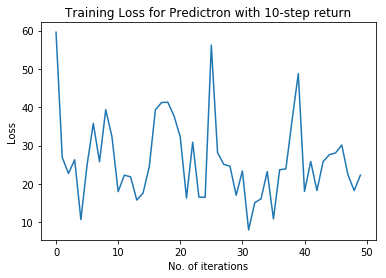

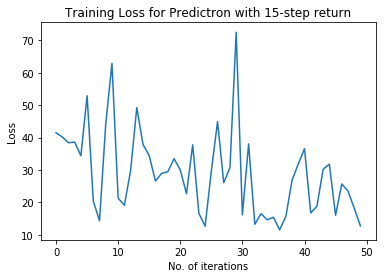

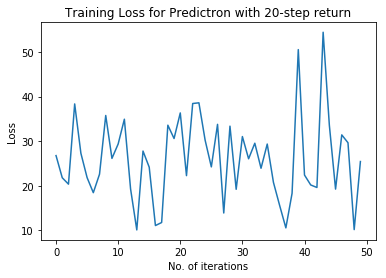

In [12]:
n_epochs = 50 # or whatever
batch_size = 256# or whatever

for k in k_values:
    
    loss_fn = nn.MSELoss()

    core = Predictronv4(x.shape[1], 4, k)
    
    optimizer = optim.Adam(core.parameters(), lr = 1e-3) 
    
    losses=[]
    
    for epoch in range(n_epochs):

        # x is our input
        permutation = torch.randperm(x.size()[0])

        for i in range(0,x.size()[0], batch_size):
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x[indices], y_target[indices]

            # in case you wanted a semi-full example
            outputs = core.forward(batch_x)
            loss = loss_fn(outputs,batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
    
    #torch.save(core.state_dict(), "training_FD001_k" +str(k)+".pth")
    torch.save(core.OH.state_dict(), "OH_training_FD001_k" + str(k) + ".pth")
    torch.save(core.HR.state_dict(), "HR_training_FD001_k" + str(k) + ".pth")
    torch.save(core.HV.state_dict(), "HV_training_FD001_k" + str(k) + ".pth")
    
    
    plt.plot(losses)
    plt.xlabel("No. of iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss for Predictron with "+str(k)+"-step return")
    plt.show()